In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.optim as optim
import gc

# from sklearn import svm, decomposition
from preprocess import remove_high_freq, whitening, from_cifar_to_np, from_submit_to_np
from plot import imshow
from util import trainNN, cal_accuracy, cal_class_accuracy, get_submit_result, export_to_file
from models import *

use_pca = False
use_forieum = False
export_csv = True
csv_name = 'res5.csv'

In [3]:
print('==> Preparing data..')
transform_train = transforms.Compose(
    [
         transforms.RandomCrop(32, padding=4),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.RandomCrop(32, padding=4),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 

transform_test = transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
         remove_high_freq
    ]) if use_forieum else transforms.Compose(
    [
         transforms.ToTensor(),
         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]) 


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=0)
submitset = np.load("./test/y_test.npy")

submit_images = [ transform_test(img) for img in submitset]

submitloader = torch.utils.data.DataLoader(submit_images, batch_size=2,
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [4]:
trainX, trainY = from_cifar_to_np(trainloader)
if not use_forieum:
    trainX = np.reshape(trainX, (50000, 3072))
print(trainX.shape)
print(trainY.shape)

(50000, 3072)
(50000,)


In [5]:
testX, testY = from_cifar_to_np(testloader)
if not use_forieum:
    testX = np.reshape(testX, (10000, 3072))
print(testX.shape)
print(testY.shape)

(10000, 3072)
(10000,)


In [6]:
submitX = from_submit_to_np(submitloader)
if not use_forieum:
    submitX = np.reshape(submitX, (12000, 3072))
print(submitX.shape)

(12000, 3072)


In [7]:
# Assume that we are on a CUDA machine, then this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


torch.Size([16, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 frog  frog  ship plane plane   car horse plane


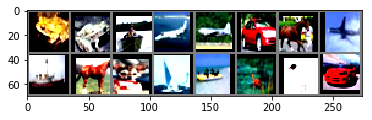

In [8]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# print(images)
print(images.size())

# show images in a batch, which contains 8 images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [9]:
print('==> Building model..')
net = SeventySevenNet()
net = net.to(device)
criterion = nn.CrossEntropyLoss()

==> Building model..


In [10]:
for i in range(3): 
    optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.002)
    trainNN(net, trainloader, optimizer, criterion,  4)

    print('Accuracy of the network on the 10000 test images: %f %%' % (
        100 * cal_accuracy(net, testloader)))
    print('Accuracy of the network on the train images: %f %%' % (
        100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.3854945
[1,   800] loss: 0.3413796
[1,  1200] loss: 0.3131114
[1,  1600] loss: 0.2932232
[1,  2000] loss: 0.2786194
[1,  2400] loss: 0.2665614
[1,  2800] loss: 0.2491848
[2,   400] loss: 0.2351100
[2,   800] loss: 0.2222595
[2,  1200] loss: 0.2155354
[2,  1600] loss: 0.2094096
[2,  2000] loss: 0.2136832
[2,  2400] loss: 0.2027678
[2,  2800] loss: 0.2019678
[3,   400] loss: 0.1894467
[3,   800] loss: 0.1944612
[3,  1200] loss: 0.1880634
[3,  1600] loss: 0.1845522
[3,  2000] loss: 0.1857449
[3,  2400] loss: 0.1866398
[3,  2800] loss: 0.1825969
[4,   400] loss: 0.1772189
[4,   800] loss: 0.1735798
[4,  1200] loss: 0.1730090
[4,  1600] loss: 0.1770210
[4,  2000] loss: 0.1751333
[4,  2400] loss: 0.1713514
[4,  2800] loss: 0.1732840
Accuracy of the network on the 10000 test images: 71.210000 %
Accuracy of the network on the train images: 71.156000 %
Training starts
[1,   400] loss: 0.1690925
[1,   800] loss: 0.1675472
[1,  1200] loss: 0.1690937
[1,  1600] l

In [11]:
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * cal_accuracy(net, testloader)))
print('Accuracy of the network on the train images: %f %%' % (
    100 * cal_accuracy(net, trainloader)))

Accuracy of the network on the 10000 test images: 76.200000 %
Accuracy of the network on the train images: 75.952000 %


In [12]:
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.002 )
trainNN(net, trainloader, optimizer, criterion,  7)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * cal_accuracy(net, testloader)))
print('Accuracy of the network on the train images: %f %%' % (
    100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.1270226
[1,   800] loss: 0.1241025
[1,  1200] loss: 0.1223759
[1,  1600] loss: 0.1219294
[1,  2000] loss: 0.1244263
[1,  2400] loss: 0.1203369
[1,  2800] loss: 0.1192475
[2,   400] loss: 0.1155839
[2,   800] loss: 0.1149159
[2,  1200] loss: 0.1190233
[2,  1600] loss: 0.1177945
[2,  2000] loss: 0.1148676
[2,  2400] loss: 0.1196846
[2,  2800] loss: 0.1134921
[3,   400] loss: 0.1166000
[3,   800] loss: 0.1189233
[3,  1200] loss: 0.1129921
[3,  1600] loss: 0.1121212
[3,  2000] loss: 0.1113095
[3,  2400] loss: 0.1134366
[3,  2800] loss: 0.1167386
[4,   400] loss: 0.1117372
[4,   800] loss: 0.1071629
[4,  1200] loss: 0.1121594
[4,  1600] loss: 0.1138032
[4,  2000] loss: 0.1104694
[4,  2400] loss: 0.1145821
[4,  2800] loss: 0.1104603
[5,   400] loss: 0.1118659
[5,   800] loss: 0.1088942
[5,  1200] loss: 0.1120727
[5,  1600] loss: 0.1131697
[5,  2000] loss: 0.1112632
[5,  2400] loss: 0.1082243
[5,  2800] loss: 0.1151708
[6,   400] loss: 0.1068872
[6,   800] l

In [13]:
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.002 )
trainNN(net, trainloader, optimizer, criterion,  7)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * cal_accuracy(net, testloader)))
print('Accuracy of the network on the train images: %f %%' % (
    100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.1104557
[1,   800] loss: 0.1097344
[1,  1200] loss: 0.1097472
[1,  1600] loss: 0.1042457
[1,  2000] loss: 0.1056839
[1,  2400] loss: 0.1101569
[1,  2800] loss: 0.1061935
[2,   400] loss: 0.1053210
[2,   800] loss: 0.1067554
[2,  1200] loss: 0.1024457
[2,  1600] loss: 0.1073796
[2,  2000] loss: 0.1069961
[2,  2400] loss: 0.1053643
[2,  2800] loss: 0.1055987
[3,   400] loss: 0.1042905
[3,   800] loss: 0.1024759
[3,  1200] loss: 0.1064414
[3,  1600] loss: 0.1045210
[3,  2000] loss: 0.1062621
[3,  2400] loss: 0.1046472
[3,  2800] loss: 0.1111901
[4,   400] loss: 0.1054438
[4,   800] loss: 0.1109682
[4,  1200] loss: 0.1088815
[4,  1600] loss: 0.1040429
[4,  2000] loss: 0.1061686
[4,  2400] loss: 0.1039143
[4,  2800] loss: 0.1029071
[5,   400] loss: 0.0999702
[5,   800] loss: 0.1048853
[5,  1200] loss: 0.1063934
[5,  1600] loss: 0.1044942
[5,  2000] loss: 0.1045156
[5,  2400] loss: 0.1060795
[5,  2800] loss: 0.1037030
[6,   400] loss: 0.1071064
[6,   800] l

In [14]:
# train(net, optimizer, 4)
optimizer = optim.SGD(net.parameters(), lr=3e-5, momentum=0.9, weight_decay=0.002)
trainNN(net, trainloader, optimizer, criterion,  3)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * cal_accuracy(net, testloader)))
print('Accuracy of the network on the train images: %f %%' % (
    100 * cal_accuracy(net, trainloader)))
## Run one more time: 80.750000 %  96.162000 %
## Run one more time:

Training starts
[1,   400] loss: 0.1051600
[1,   800] loss: 0.1026486
[1,  1200] loss: 0.1021035
[1,  1600] loss: 0.0981974
[1,  2000] loss: 0.1038399
[1,  2400] loss: 0.1044060
[1,  2800] loss: 0.1001787
[2,   400] loss: 0.1051461
[2,   800] loss: 0.0967614
[2,  1200] loss: 0.1018014
[2,  1600] loss: 0.1003812
[2,  2000] loss: 0.1026958
[2,  2400] loss: 0.0999770
[2,  2800] loss: 0.1012882
[3,   400] loss: 0.1025978
[3,   800] loss: 0.0992478
[3,  1200] loss: 0.1004882
[3,  1600] loss: 0.1004317
[3,  2000] loss: 0.0997749
[3,  2400] loss: 0.1028741
[3,  2800] loss: 0.1040129
Accuracy of the network on the 10000 test images: 81.530000 %
Accuracy of the network on the train images: 82.568000 %


In [15]:
optimizer = optim.SGD(net.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.002)
trainNN(net, trainloader, optimizer, criterion,  5)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * cal_accuracy(net, testloader)))
print('Accuracy of the network on the train images: %f %%' % (
    100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.1014373
[1,   800] loss: 0.1006993
[1,  1200] loss: 0.1020130
[1,  1600] loss: 0.1034253
[1,  2000] loss: 0.1052340
[1,  2400] loss: 0.1000731
[1,  2800] loss: 0.1061036
[2,   400] loss: 0.1047262
[2,   800] loss: 0.1015895
[2,  1200] loss: 0.1008627
[2,  1600] loss: 0.0994981
[2,  2000] loss: 0.1024375
[2,  2400] loss: 0.1060625
[2,  2800] loss: 0.0994561
[3,   400] loss: 0.0981782
[3,   800] loss: 0.1023968
[3,  1200] loss: 0.0998526
[3,  1600] loss: 0.0979407
[3,  2000] loss: 0.1038625
[3,  2400] loss: 0.1073632
[3,  2800] loss: 0.1015024
[4,   400] loss: 0.1018139
[4,   800] loss: 0.1010480
[4,  1200] loss: 0.0989015
[4,  1600] loss: 0.1001054
[4,  2000] loss: 0.1022085
[4,  2400] loss: 0.1038936
[4,  2800] loss: 0.0954416
[5,   400] loss: 0.1027358
[5,   800] loss: 0.1007566
[5,  1200] loss: 0.1007001
[5,  1600] loss: 0.0963469
[5,  2000] loss: 0.0970737
[5,  2400] loss: 0.1024909
[5,  2800] loss: 0.1046695
Accuracy of the network on the 10000 te

In [16]:
# train(net, optimizer, 4)
optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9, weight_decay=0.002)
#optimizer = optim.Adam(net.parameters(), lr=0.00003, weight_decay=0.001)
trainNN(net, trainloader, optimizer, criterion,  4)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * cal_accuracy(net, testloader)))
print('Accuracy of the network on the train images: %f %%' % (
    100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.0975311
[1,   800] loss: 0.0989898
[1,  1200] loss: 0.0977084
[1,  1600] loss: 0.1006338
[1,  2000] loss: 0.0953439
[1,  2400] loss: 0.0996015
[1,  2800] loss: 0.0970268
[2,   400] loss: 0.1017010
[2,   800] loss: 0.0983132
[2,  1200] loss: 0.0977607
[2,  1600] loss: 0.0988984
[2,  2000] loss: 0.0973502
[2,  2400] loss: 0.0966553
[2,  2800] loss: 0.0958375
[3,   400] loss: 0.1005357
[3,   800] loss: 0.1027925
[3,  1200] loss: 0.0920095
[3,  1600] loss: 0.1034133
[3,  2000] loss: 0.0973950
[3,  2400] loss: 0.0996756
[3,  2800] loss: 0.0955737
[4,   400] loss: 0.0993542
[4,   800] loss: 0.0994074
[4,  1200] loss: 0.0959725
[4,  1600] loss: 0.0965140
[4,  2000] loss: 0.0981090
[4,  2400] loss: 0.0954768
[4,  2800] loss: 0.0978752
Accuracy of the network on the 10000 test images: 81.610000 %
Accuracy of the network on the train images: 82.968000 %


In [30]:
# train(net, optimizer, 4)
optimizer = optim.SGD(net.parameters(), lr=1e-6, momentum=0.9, weight_decay=0.002)
#optimizer = optim.Adam(net.parameters(), lr=0.00003, weight_decay=0.001)
trainNN(net, trainloader, optimizer, criterion,  4)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * cal_accuracy(net, testloader)))
print('Accuracy of the network on the train images: %f %%' % (
    100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.0995893
[1,   800] loss: 0.0977249
[1,  1200] loss: 0.0991909
[1,  1600] loss: 0.0950588
[1,  2000] loss: 0.0987140
[1,  2400] loss: 0.1002645
[1,  2800] loss: 0.0986131
[2,   400] loss: 0.1004868
[2,   800] loss: 0.0973908
[2,  1200] loss: 0.0944646
[2,  1600] loss: 0.0969740
[2,  2000] loss: 0.0967925
[2,  2400] loss: 0.0982371
[2,  2800] loss: 0.0989740
[3,   400] loss: 0.0974015
[3,   800] loss: 0.0975136
[3,  1200] loss: 0.0993545
[3,  1600] loss: 0.0998423
[3,  2000] loss: 0.0995795
[3,  2400] loss: 0.0953791
[3,  2800] loss: 0.0989352
[4,   400] loss: 0.0983798
[4,   800] loss: 0.0977180
[4,  1200] loss: 0.1027871
[4,  1600] loss: 0.0938793
[4,  2000] loss: 0.0972928
[4,  2400] loss: 0.0982407
[4,  2800] loss: 0.0967378
Accuracy of the network on the 10000 test images: 81.650000 %
Accuracy of the network on the train images: 83.122000 %


In [31]:
# train(net, optimizer, 4)
optimizer = optim.SGD(net.parameters(), lr=5e-6, momentum=0.9, weight_decay=0.003)
#optimizer = optim.Adam(net.parameters(), lr=0.00003, weight_decay=0.001)
trainNN(net, trainloader, optimizer, criterion,  4)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * cal_accuracy(net, testloader)))
print('Accuracy of the network on the train images: %f %%' % (
    100 * cal_accuracy(net, trainloader)))

Training starts
[1,   400] loss: 0.0982009
[1,   800] loss: 0.1020847
[1,  1200] loss: 0.0977753
[1,  1600] loss: 0.0977947
[1,  2000] loss: 0.0979547
[1,  2400] loss: 0.0985012
[1,  2800] loss: 0.0965023
[2,   400] loss: 0.0963587
[2,   800] loss: 0.0992967
[2,  1200] loss: 0.0941778
[2,  1600] loss: 0.0986284
[2,  2000] loss: 0.1031297
[2,  2400] loss: 0.0989829
[2,  2800] loss: 0.0964645
[3,   400] loss: 0.0982634
[3,   800] loss: 0.0949813
[3,  1200] loss: 0.0946948
[3,  1600] loss: 0.0983177
[3,  2000] loss: 0.0976546
[3,  2400] loss: 0.0992133
[3,  2800] loss: 0.1029353
[4,   400] loss: 0.0986408
[4,   800] loss: 0.1002220
[4,  1200] loss: 0.0996013
[4,  1600] loss: 0.0980114
[4,  2000] loss: 0.0976525
[4,  2400] loss: 0.0949390
[4,  2800] loss: 0.0992783
Accuracy of the network on the 10000 test images: 81.760000 %
Accuracy of the network on the train images: 82.874000 %


In [32]:
params = list(net.parameters())
print(len(params))

44


In [18]:
cal_class_accuracy(net, testloader)

NameError: name 'classes' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


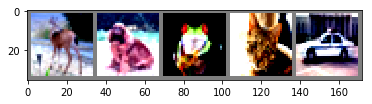

In [33]:
images = submit_images[2100:2105]
imshow(torchvision.utils.make_grid(images))

(2, 3, 32, 32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


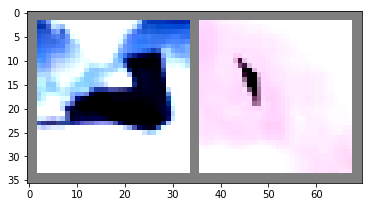

In [34]:
dataiter = iter(submitloader)
images = dataiter.next()
print(np.array(images).shape)
imshow(torchvision.utils.make_grid(images))

In [35]:
gc.collect()

2359

In [36]:
# res_labels = get_submit_result(net, submitloader)
res_per = []
with torch.no_grad():
    for i, data in enumerate(submitloader, 0):
        inputs = data.to(device)
        # forward + backward + optimize
        outputs = net(inputs)
        for o in outputs:
            res_per.append(o)
res_labels = [int(torch.max(t,0)[1]) for t in res_per]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 deer   dog  frog  frog   car   car   cat  frog  ship horse  deer plane  bird  bird   car   cat plane   dog  frog horse


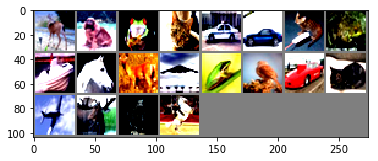

In [39]:
images = submit_images[2100:2120]
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[res_labels[j]] for j in range(2100,2120)))

In [40]:
if export_csv:
    export_to_file(csv_name, res_labels)